In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import skfuzzy as fuzz

In [14]:
image_dir = "/content/drive/MyDrive/GroundTruths_bmpformat/Test_bmp"
gt_dir    = "/content/drive/MyDrive/GroundTruths_bmpformat/Test_GT_bmp"

img_files = sorted(os.listdir(image_dir))[:25] #Considering only the first 25 images for computation
gt_files  = sorted(os.listdir(gt_dir))

print("Images:", len(img_files))

Images: 25


In [15]:
def split_nuc_cyto(gt):

    nucleus = np.zeros_like(gt)
    cytoplasm = np.zeros_like(gt)

    nucleus[gt == 100] = 1
    cytoplasm[gt == 255] = 1

    return nucleus, cytoplasm

In [16]:
def dice_score(pred, gt):

    intersection = np.sum(pred * gt)
    total = np.sum(pred) + np.sum(gt)

    return (2 * intersection) / (total + 1e-8)

In [17]:
def kmeans_segmentation(img):

    pixels = img.reshape(-1, 3)

    kmeans = KMeans(n_clusters=3, random_state=0)
    labels = kmeans.fit_predict(pixels)

    segmented = labels.reshape(img.shape[:2])

    return segmented

In [18]:
def fcm_segmentation(img):

    pixels = img.reshape(-1, 3).T

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels, c=3, m=2, error=0.005, maxiter=1000
    )

    labels = np.argmax(u, axis=0)
    segmented = labels.reshape(img.shape[:2])

    return segmented

In [19]:
dice_kmeans = []
dice_fcm = []

for i in range(len(img_files)):

    img = cv2.imread(os.path.join(image_dir, img_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(os.path.join(gt_dir, gt_files[i]), 0)

    gt_nuc, gt_cyto = split_nuc_cyto(gt)

    # ---- KMEANS ----
    seg_k = kmeans_segmentation(img)

    # Assume cluster with smallest mean intensity = nucleus
    nuc_cluster_k = np.argmin([img[seg_k==c].mean() for c in range(3)])
    pred_nuc_k = (seg_k == nuc_cluster_k).astype(int)

    dice_kmeans.append(dice_score(pred_nuc_k, gt_nuc))

    # ---- FCM ----
    seg_f = fcm_segmentation(img)

    nuc_cluster_f = np.argmin([img[seg_f==c].mean() for c in range(3)])
    pred_nuc_f = (seg_f == nuc_cluster_f).astype(int)

    dice_fcm.append(dice_score(pred_nuc_f, gt_nuc))

In [20]:
print("Average Dice - KMeans :", np.mean(dice_kmeans))
print("Average Dice - FCM    :", np.mean(dice_fcm))

Average Dice - KMeans : 0.7743964158671278
Average Dice - FCM    : 0.7107033651642913


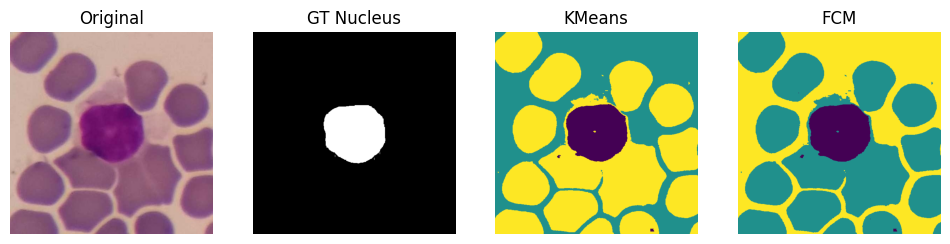

In [21]:
img = cv2.imread(os.path.join(image_dir, img_files[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt = cv2.imread(os.path.join(gt_dir, gt_files[0]), 0)
gt_nuc, gt_cyto = split_nuc_cyto(gt)

seg_k = kmeans_segmentation(img)
seg_f = fcm_segmentation(img)

plt.figure(figsize=(12,5))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_nuc, cmap='gray')
plt.title("GT Nucleus")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(seg_k)
plt.title("KMeans")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(seg_f)
plt.title("FCM")
plt.axis("off")

plt.show()